# Contrôle de TP Apprentissage Automatique 1

Le but de cette séance est d'évaluer vos compétences sur un projet d'apprentissage profond en utilisant un nouveau corpus.

Contrairement aux séances précédentes, nous allons travailler cette fois-ci sur un corpus audio contenant 10 classes (craquement de feu, horloge, chant de coq, etc...).

Les fichiers audio sont convertis en spectrogrammes, une représentation temps/fréquence du signal qui peut être vue comme une image. Ce spectrogramme est passé à un réseau de neurones pour effectuer la classification de l'audio comme réprésenté par la figure : 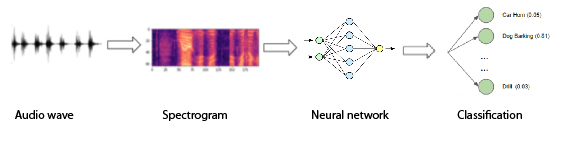


### Imports



In [ ]:
import os
import random
import requests
import zipfile
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


import numpy as np
import matplotlib.pyplot as plt

Installation de la bibliothèque **librosa** qui lit les fichiers audio et extrait les spectrogrammes qui seront traités ensuite comme des images.

In [ ]:
!pip -q install librosa
import librosa
import librosa.display

###1. Chargement du corpus

Le corpus est constitué de 10 concepts audio qui sont :
* **tronçonneuse** *(chainsaw)*
* **tic-tac d'une horloge** *(clock_tick)*
* **craquement de feu** *(crackling_fire)*
* **pleurs de bébé** *(crying_baby)*
* **chien** *(dog)*
* **hélicoptère** *(helicopter)*
* **pluie** *(rain)*
* **coq** *(rooster)*
* **bruit des vagues** *(sea_waves)*
* **éternuement** *(sneezing)*

Nous voulons classer les différents fichiers audio suivant ces 10 classes.

#### Téléchargement du corpus


In [ ]:
!wget -O dataset.zip https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
!unzip -qq dataset.zip -d data/
!rm dataset.zip

--2023-04-22 11:04:13--  https://www.irit.fr/~Thomas.Pellegrini/ens/M2RFA/dataset.zip
Resolving www.irit.fr (www.irit.fr)... 141.115.28.2
Connecting to www.irit.fr (www.irit.fr)|141.115.28.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 128685900 (123M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>] 122.72M  3.33MB/s    in 38s     

2023-04-22 11:04:51 (3.25 MB/s) - ‘dataset.zip’ saved [128685900/128685900]

replace data/test/chainsaw/1-64398-B-41.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: e
replace data/test/chainsaw/1-19898-B-41.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: r
replace data/test/chainsaw/1-47250-A-41.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: r
replace data/r? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: r
replace data/r? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: r
replace data/r? [y]es, [n]o, [A]ll, [N]one, [r]ename: r
new name: r
replace data/r? [y]es

La base de données téléchargée est stockée dans :

```
./data
```
Vous pouvez visualiser l'arborescence des données dans la colonne de gauche sous l'onglet *Fichiers* et en cliquant sur le bouton *actualiser* si les données n'apparaissent pas.

In [ ]:
base_dir = './data'

#### Chargement du corpus dans la mémoire

La fonction **load_dataset** permet de charger les données d'apprentissage ou les données de test en mémoire.

**Attention :** le chargement est un peu long (environ 2min)

In [ ]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']


def load_dataset(path):
    spec = []
    labels = []
    for idx, label in enumerate(idx_to_classes):
        with os.scandir(os.path.join(path, label)) as it:
            for entry in it:
                if (not entry.name.startswith('.')
                        and entry.name.endswith('.wav')):
                    # load audio
                    y, sr = librosa.load(entry.path)
                    # convert audio to melspectrogram
                    spec.append(librosa.core.power_to_db(librosa.feature.melspectrogram(y=y, sr=sr,
                                                              n_fft=2048,
                                                              hop_length=512,
                                                              power=2.0)))
                    
                    # add associated label
                    labels.append(idx)

    # mélange les données 
    #combined = list(zip(spec, labels))
    #random.shuffle(combined)
    #spec, labels = zip(*combined)
    return np.array(spec), np.array(labels)

In [ ]:
%%time

print("Chargement du corpus d'apprentissage")
train_dir = os.path.join(base_dir, 'train')
x_train, y_train = load_dataset(train_dir)

print("Chargement du corpus de test")
test_dir = os.path.join(base_dir, 'test')
x_test, y_test = load_dataset(test_dir)

Chargement du corpus d'apprentissage
Chargement du corpus de test
CPU times: user 8.14 s, sys: 5.86 s, total: 14 s
Wall time: 9.5 s


#### Taille du corpus

Affichage de la taille du corpus. Pour cela, il suffit de compter le nombre d'images qu'il y a dans les dossiers correspondant à chaque label aussi bien dans le corpus d'apprentissage que dans le corpus de test.

In [ ]:
# Affichage du nombre d'exemples totales dans le corpus
print('Taille du corpus total')
print('\t• train :', len(x_train), 'exemples')
print('\t• test :', len(x_test), 'exemples')

# Affichage de la taille des images et des labels dans le corpus 
print('\nTaille des données d\'apprentissage')
print('\t• X_train (images) :', x_train.shape)
print('\t• y_train (labels) :', y_train.shape)

print('\nTaille des données de test')
print('\t• X_test (images) :', x_test.shape)
print('\t• y_test (labels) :', y_test.shape)

Taille du corpus total
	• train : 320 exemples
	• test : 80 exemples

Taille des données d'apprentissage
	• X_train (images) : (320, 128, 216)
	• y_train (labels) : (320,)

Taille des données de test
	• X_test (images) : (80, 128, 216)
	• y_test (labels) : (80,)


**Correspondance ID du label / signification**

Définition de la liste *idx_to_classes* permettant à partir de la valeur du label de retrouver sa signification

In [ ]:
idx_to_classes = ['chainsaw', 'clock_tick', 'crackling_fire', 'crying_baby',
                  'dog', 'helicopter', 'rain', 'rooster', 'sea_waves',
                  'sneezing']

# du corpus d'apprentissage
print("Affichage de la correspondance des labels :")
for i in range(10):
    n = random.randint(0, len(y_train)-1)
    print('• y_train[' + str(n) + '] =', y_train[n], '->', idx_to_classes[y_train[n]])

Affichage de la correspondance des labels :
• y_train[314] = 9 -> sneezing
• y_train[223] = 6 -> rain
• y_train[88] = 2 -> crackling_fire
• y_train[221] = 6 -> rain
• y_train[219] = 6 -> rain
• y_train[53] = 1 -> clock_tick
• y_train[233] = 7 -> rooster
• y_train[178] = 5 -> helicopter
• y_train[264] = 8 -> sea_waves
• y_train[269] = 8 -> sea_waves


**Affichage de quelques spectrogrammes**


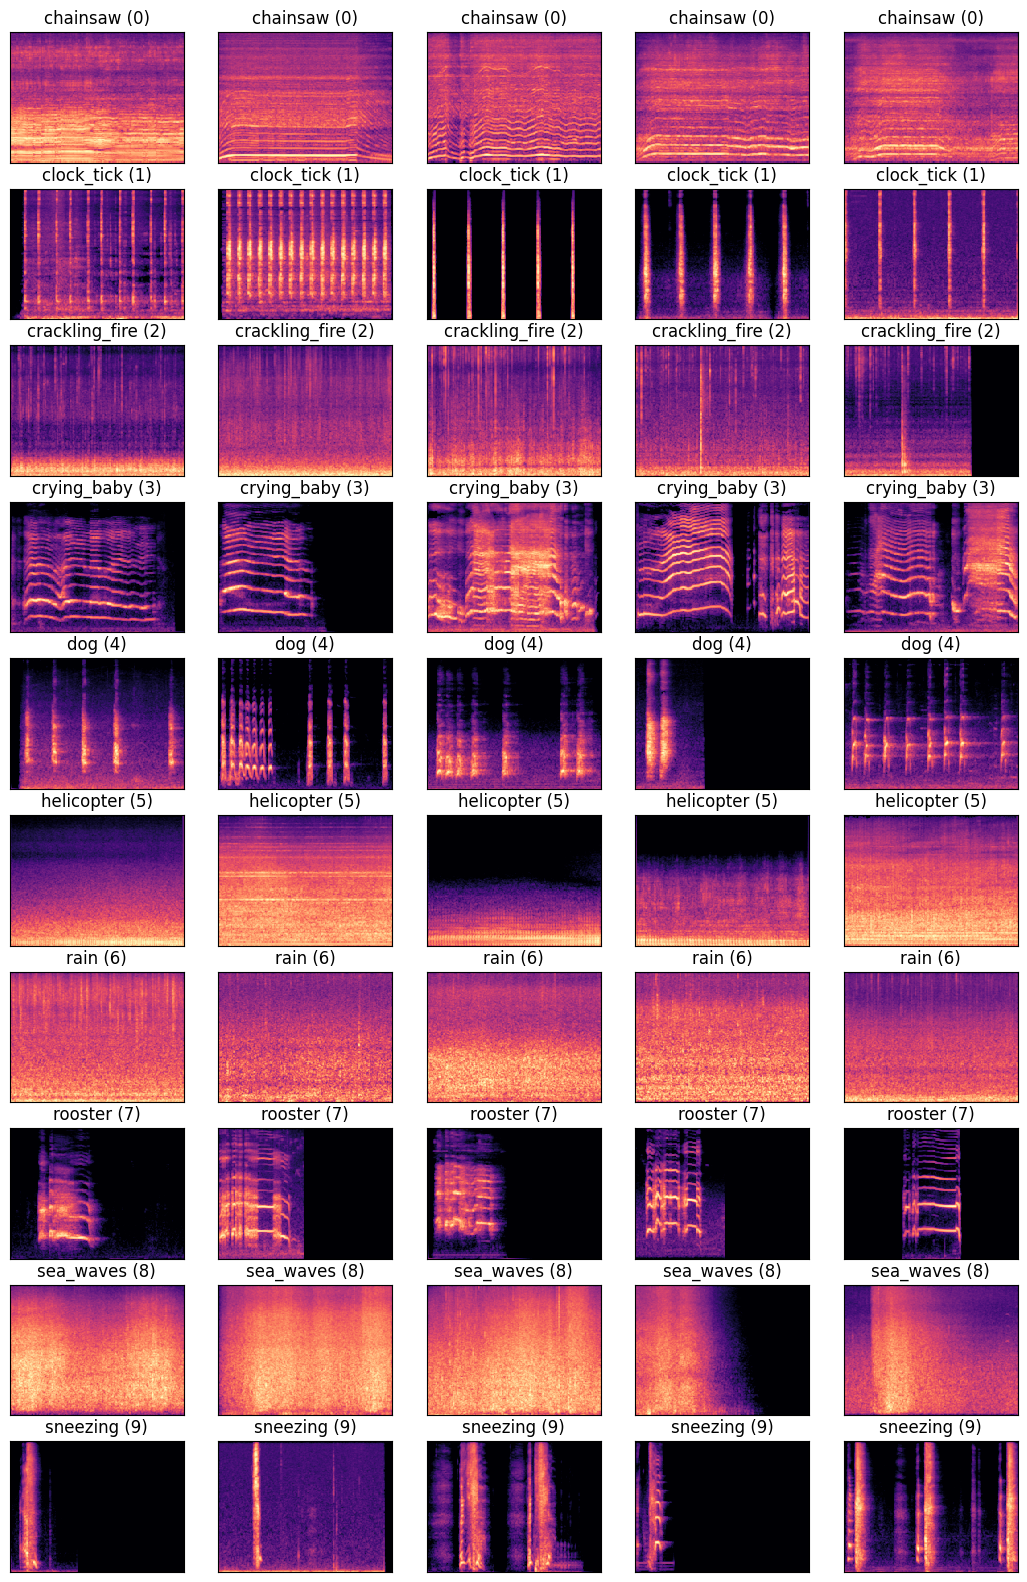

In [ ]:
plt.figure(figsize=(13,20))

n = 0
for i in range(10):
    for j in range(5):
        # récupération d'une image et de son label associé
        img, target = x_train[n+j], y_train[n+j]
        # affiche du spectrogramme
        plt.subplot(10,5,i*5+j+1)
        # img = librosa.power_to_db(img)
        librosa.display.specshow(img, cmap='magma')
        # ajout d'un titre à l'image
        plt.title('{} ({})'.format(idx_to_classes[target], target))
        #plt.colorbar(format='%+2.0f dB')
    n += 32
              
plt.show()

## 2. Générateurs de données pour Pytorch

Création d'un générateur de données (un « DataLoader ») pour les jeux de train et de test

In [ ]:
nb_classes = 10

# numpy vers tensors
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)


height = x_train[0].shape[0]
width = x_train[0].shape[1]
print(height, width)

# numpy vers tensors
X_train = torch.from_numpy(x_train)
X_test = torch.from_numpy(x_test)


128 216


In [ ]:
class Dataset(torch.utils.data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, x_data, y_labels):
        'Initialization'
        self.y = y_labels
        self.x = x_data

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.x)

  def __getitem__(self, index):
        'Generates one sample of data'
        # Select sample
        X = self.x[index].unsqueeze_(0)
        y = self.y[index]

        return X, y

dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)

In [ ]:
batch_size=32

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=1)

## 3. Classification de fichiers audio en utilisant de l'apprentissage profond

Maintenant c'est à vous de jouer, vous devez implémenter différentes architectures de réseaux de neurones à partir de vos connaissances et ceux que vous avez vu dans les séances précédentes.

Pour cela, vous devez :
* complèter l'architecture MLP puis celle du CNN plus bas;
* lancer l'apprentissage ;
* évaluer les modèles sur le jeu de test ;


### Réseau MLP

Dans cette section, il faut compléter le réseau dense ci-dessous, qui contient une couche cachée avec la fonction d'activation ReLU et une couche de sortie.

In [ ]:
# Perceptron multi-couche 
class MLP(nn.Module):
    def __init__(self, num_hidden=50):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(height*width , num_hidden)
        self.layer2 = nn.Linear(num_hidden, nb_classes)
        # vous pouvez définir d'autres couches dans un deuxième temps

    def forward(self, spectro):
        flattened = spectro.view(-1, height*width) # flatten le spectro
        activation1 = self.layer1(flattened)
        activation1 = torch.sigmoid(activation1)
        activation2 = self.layer2(activation1)
        return activation2

Compléter la fonction d'apprentissage

In [ ]:
def train(model, batch_size=32, weight_decay=0.0,
          optimizer="sgd", learning_rate=0.1, momentum=0.9, 
          num_epochs=10):
    
    # la loss 
    criterion = nn.CrossEntropyLoss()
    # l'optimiseur
    assert optimizer in ("sgd", "adam")
    if optimizer == "sgd":
        optimizer = optim.SGD(model.parameters(),
                              lr=learning_rate,
                              momentum=momentum,
                              weight_decay=weight_decay)
    else:
        optimizer = optim.Adam(model.parameters(),
                               lr=learning_rate,
                               weight_decay=weight_decay)
    # on track la learning curve avec des listes
    iters, iters_acc, losses, train_acc, val_acc = [], [], [], [], []
    # training
    n = 0 # nombre d'iterations (pour faire des figures)
    for epoch in range(num_epochs):
        for imgs, labels in iter(train_loader):
            # if imgs.size()[0] < batch_size:
            #     continue
            # print(imgs.size())

            model.train() # met le modèle en mode train
            out = model(imgs)
            loss = criterion(out,labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # sauvegarde iteration et loss
            iters.append(n)
            losses.append(float(loss)/batch_size)             # loss moyen

            if n % 20 == 0 :
              train_acc.append(get_accuracy(model, train=True)) # training accuracy 
              val_acc.append(get_accuracy(model, train=False))  # test accuracy
              iters_acc.append(n)

            n += 1

    # plotting
    plt.title("Courbe d'apprentissage")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Courbe d'apprentissage")
    plt.plot(iters_acc, train_acc, label="Train")
    plt.plot(iters_acc, val_acc, label="Test")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Précision finale Train : {}".format(train_acc[-1]))
    print("Précision finale Test : {}".format(val_acc[-1]))

In [ ]:
def get_accuracy(model, train=False):
    if train:
        data = train_loader
    else:
        data = test_loader

    model.eval() # met le modèle en mode test (inhibe le dropout par exemple)
    correct = 0
    total = 0
    for inp, labels in data:
        output = model(inp) # pas besoin de torch.softmax
        pred = output.max(1, keepdim=True)[1] # retrouve l'indice de la log-proba maximale
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += inp.shape[0]
    return correct / total

Instancier un MLP avec 50 neurones pour la couche cachée. Quel est le nombre de paramètres de ce modèle ?

In [ ]:
model = MLP(50)
print(model)

MLP(
  (layer1): Linear(in_features=27648, out_features=50, bias=True)
  (layer2): Linear(in_features=50, out_features=10, bias=True)
)


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

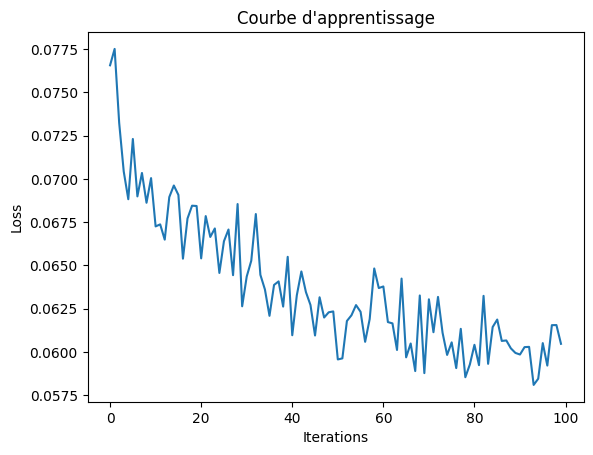

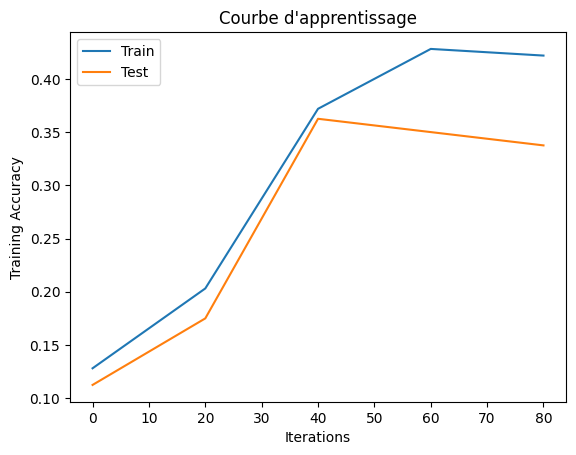

Précision finale Train : 0.421875
Précision finale Test : 0.3375


In [ ]:
train(model, learning_rate=0.0001)

On voit que le MLP n'est pas performant. Vous pourrez durant le temps que vous avez pour préparer le rapport essayer de modifier son architecture pour tenter d'améliorer ses performances.


Passons à un réseau convolutif, un CNN. 

Compléter son implémentation ci-dessous pour définir trois couches de convolution avec des noyaux de taille 3x3 et à 8, 16 et 32 canaux en sortie respectivement. 

Compléter les dimensions qui vont bien pour les deux couches fully-connected fc1 et fc2. fc1 a 50 neurones et fc2 10 neurones pour les 10 classes. 

Une ReLU sera appliquée après chaque couche de convolution et après fc1. 

Le pooling s'applique après chaque couche de convolution.

Compléter la méthode forward. Vous pouvez afficher les dimensions de la sortie de la dernière couche de convolution, après le pooling, pour déterminer la dimension que vous devez règler pour la couche fc1.


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  #height, width = 128 216
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32*16*27, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        #print(x.shape) ([32, 32, 16, 27])

        # view : Returns a new tensor with the same data as the self tensor but of a different shape
        x = x.view(-1, 32*16*27) # flatten - the size -1 is inferred from other dimensions
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

Instancier le modèle CNN et afficher son nombre de paramètres

In [ ]:
model_cnn = CNN()

In [ ]:
print("Le nombre de paramètres du modèle est :" ,sum(p.numel() for p in model_cnn.parameters() if p.requires_grad))

Le nombre de paramètres du modèle est : 697648


Tester un apprentissage de 10 epochs, avec l'optimiseur ADAM, un taux d'apprentissage à 0.0001, une taille de batch de 32 exemples.

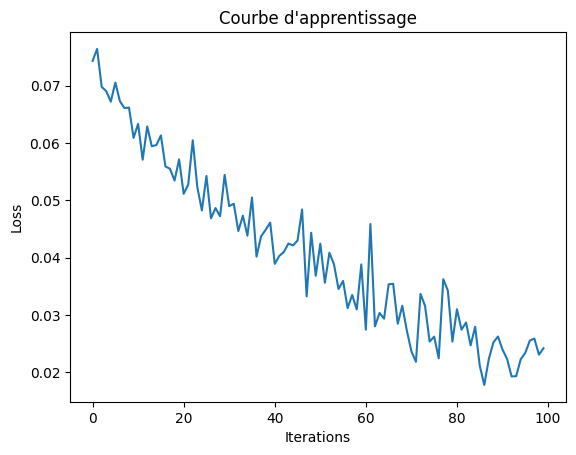

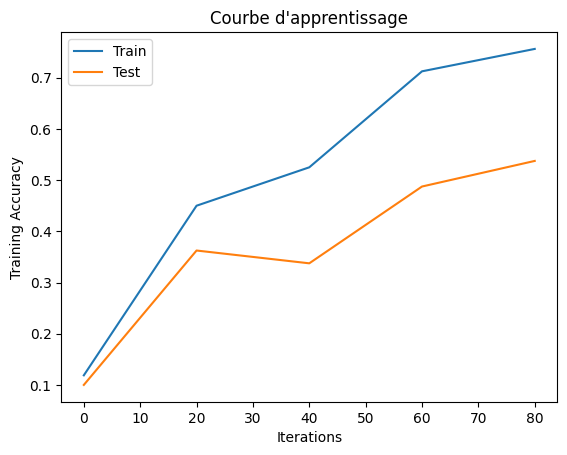

Précision finale Train : 0.75625
Précision finale Test : 0.5375


In [ ]:
train(model_cnn, optimizer="adam", learning_rate=0.0001)

In [ ]:
x_train.shape

(320, 128, 216)

## 4. Amélioration des modèles 

Essayer d'améliorer le MLP, jouer avec son architecture : changer la fonction d'activation, modifier le nombre de couches, ajouter une normalisation des activations...

Même chose avec le CNN. 

Vous pouvez améliorer les hyperparamètres d'apprentissage de la fonction train.

Essayer les deux optimiseurs proposés. L'un est-il meilleur que l'autre pour la tâche donnée ? Pensez-vous avoir une bonne valeur de taux d'apprentissage pour SGD (et pour ADAM) ?

Une fois que vous avez votre meilleur modèle, faites une matrice de confusion qui montre les pourcentages de confusion entre les 10 classes sur le jeu de test.

Pour aller plus loin : quelles augmentations pourraient êter pertinentes pour augmenter les spectrogrammes ?

###4.1 Amélioration MLP

On a commencé par l'amélioration du MLP, on a affectué des modifications au modèle de base : augmentation du nombre de neurones dans les
couches cachées de 50 à 1000 , l'utilisation de BatchNorm entre les deux couches pour eviter l'overfitting, ainsi que d'autres modifications plus détailées dans l'article.


In [ ]:
# Modification de la première architecture : 
class MLP1(nn.Module):
    def __init__(self, num_hidden=50):
        super(MLP1, self).__init__()
        self.layer1 = nn.Linear(height*width , num_hidden)
        self.bn1 = nn.BatchNorm1d(num_features=num_hidden)
        self.layer2 = nn.Linear(num_hidden, nb_classes)

    def forward(self, spectro):
        flattened = spectro.view(-1, height*width) # flatten le spectro
        activation1 = self.layer1(flattened)
        activation1 = self.bn1(activation1)
        activation1 = torch.relu(activation1)
        
        activation2 = self.layer2(activation1)

        return activation2

MLP1(
  (layer1): Linear(in_features=27648, out_features=1000, bias=True)
  (bn1): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=1000, out_features=10, bias=True)
)


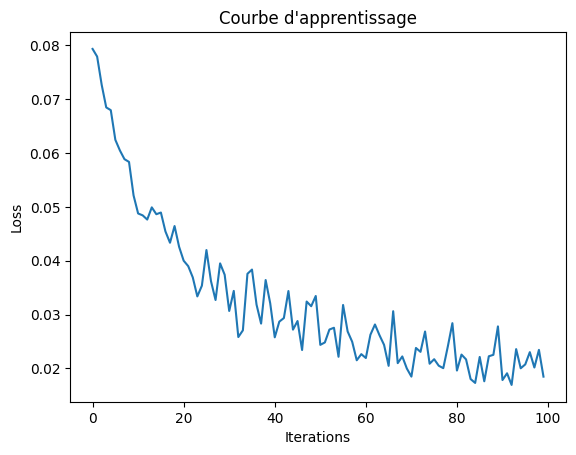

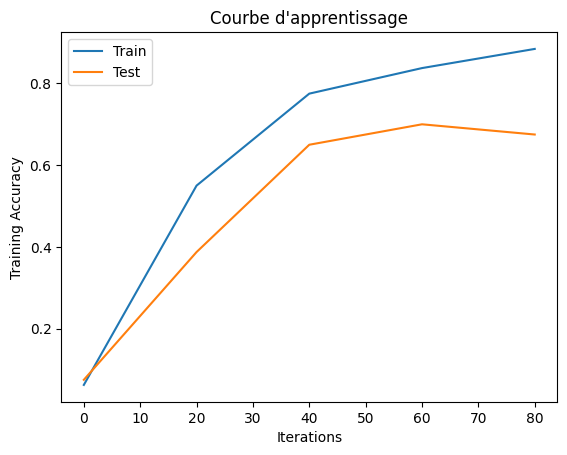

Précision finale Train : 0.884375
Précision finale Test : 0.675


In [ ]:
model_MLP1 = MLP1(1000)
print(model_MLP1)
train(model_MLP1, learning_rate=0.0001)

###4.2 Amélioration CNN
Afin d'améliorer notre cnn, on a effectuer plusieurs modification sur l'architecture du modèle (vous trouvez plus de détails sur l'article).

Le meilleur résultat est obtenu avec le modèle de base auquel on a ajouté deux couches de convolution (32, 64) et (64, 128) et on a modifié  le nombre de neurones dans la couche cachée entièrement connectée (500 au lieu de 50) et on a augmenté le nombre d’epochs à 200, cela améliore la précision du train mais produit un problème d' overfitting. Pour régler ce problème on a utilisé une "BatchNorm" après chaque couche de convolution, ce qui a amélioré la pression du test et la performance de notre modèle.


In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3, padding=1)  #height, width = 128 216
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(32)
        self.conv4 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.conv5 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128*4*6, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.bn1(self.pool(F.relu(self.conv1(x))))
        x = self.bn2(self.pool(F.relu(self.conv2(x))))
        x = self.bn3(self.pool(F.relu(self.conv3(x))))
        x = self.bn4(self.pool(F.relu(self.conv4(x))))
        x = self.bn5(self.pool(F.relu(self.conv5(x))))

        #print(x.shape)

        # view : Returns a new tensor with the same data as the self tensor but of a different shape
        x = x.view(-1, 128*4*6) # flatten - the size -1 is inferred from other dimensions
        
        #print(x.shape)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x

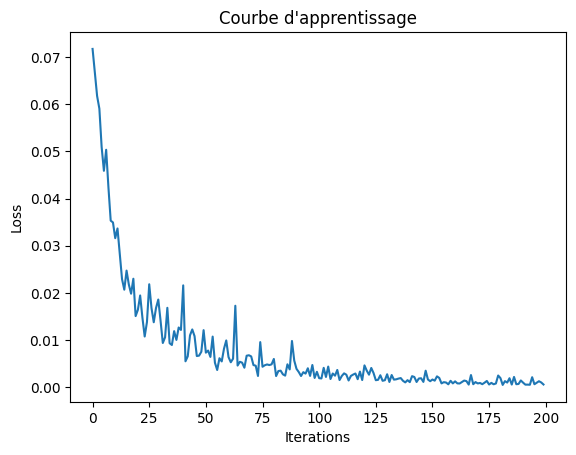

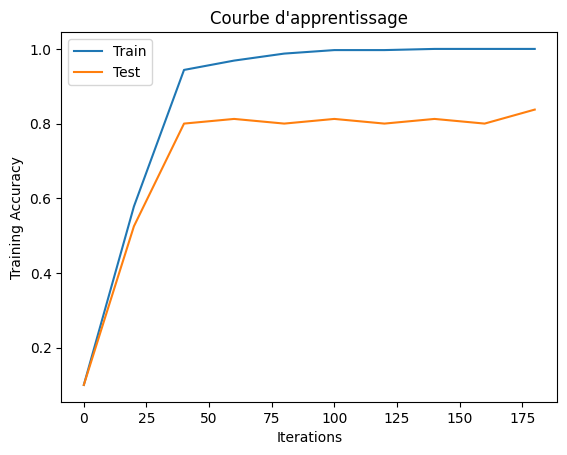

Précision finale Train : 1.0
Précision finale Test : 0.8375


In [ ]:
model_cnn = CNN()
train(model_cnn, optimizer="adam", learning_rate=0.0001,num_epochs=20)

###5.1 La matrice de confusion de MLP
matrice de confusion du meilleur MLP sur les données du test 

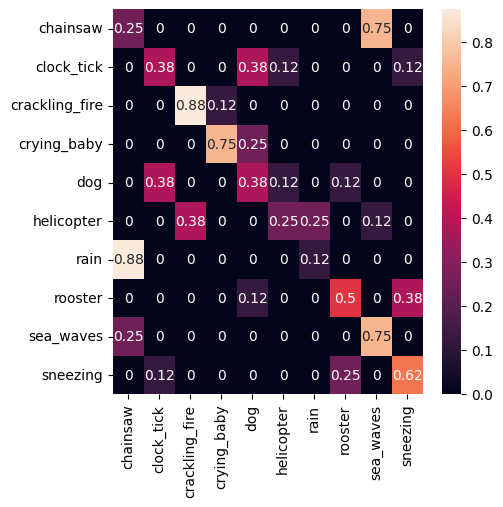

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model_MLP1(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in idx_to_classes],
                     columns = [i for i in idx_to_classes])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')

##5.1 La matrice de confusion de CNN
matrice de confusion du meilleur cnn sur les données du test 

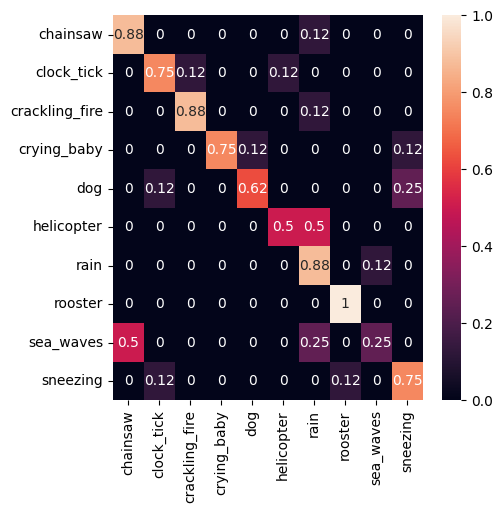

In [ ]:
y_pred = []
y_true = []

# iterate over test data
for inputs, labels in test_loader:
        output = model_cnn(inputs) # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in idx_to_classes],
                     columns = [i for i in idx_to_classes])
plt.figure(figsize = (5,5))
sn.heatmap(df_cm, annot=True)
plt.savefig('output.png')